In [1]:
from io import open
import glob
import os

import unicodedata
import string

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
print(findFiles('data/data-name/names/*.txt'))

['data/data-name/names\\Arabic.txt', 'data/data-name/names\\Chinese.txt', 'data/data-name/names\\Czech.txt', 'data/data-name/names\\Dutch.txt', 'data/data-name/names\\English.txt', 'data/data-name/names\\French.txt', 'data/data-name/names\\German.txt', 'data/data-name/names\\Greek.txt', 'data/data-name/names\\Irish.txt', 'data/data-name/names\\Italian.txt', 'data/data-name/names\\Japanese.txt', 'data/data-name/names\\Korean.txt', 'data/data-name/names\\Polish.txt', 'data/data-name/names\\Portuguese.txt', 'data/data-name/names\\Russian.txt', 'data/data-name/names\\Scottish.txt', 'data/data-name/names\\Spanish.txt', 'data/data-name/names\\Vietnamese.txt']


In [4]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [5]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [6]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [12]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data-name/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [18]:
category_lines['Chinese'][:5]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao']

In [21]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [25]:
all_letters.find('A')

26

In [27]:
import torch

In [37]:
tensor = torch.zeros(2, 10)
tensor[0][2] = 1
tensor

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [43]:
# 从所有的字母中得到某个letter的索引编号, 例如 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

lineToTensor('abc').size()


torch.Size([3, 1, 57])

In [44]:
import torch.nn as nn

In [45]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [46]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9161, -2.9086, -2.8588, -2.8670, -2.9059, -2.8114, -2.8144, -2.8868,
         -3.0301, -2.8699, -2.9467, -2.9225, -2.9352, -2.8415, -2.8406, -2.9214,
         -2.9691, -2.8102]], grad_fn=<LogSoftmaxBackward>)


In [49]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [50]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Teteruk
category = French / line = Pettigrew
category = Chinese / line = Kan
category = Vietnamese / line = Nghiem
category = English / line = Hodges
category = Czech / line = Hajkova
category = Arabic / line = Isa
category = Greek / line = Antonakos
category = Italian / line = Naldi
category = Greek / line = Geracimos


In [51]:
criterion = nn.NLLLoss()

In [52]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [53]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d  %d%% (%s) %.4f  %s / %s  %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000  5% (0m 14s) 1.9806  Wang / Chinese  ✗ (Korean)
10000  10% (0m 28s) 3.0083  Blahut / Arabic  ✗ (Czech)
15000  15% (0m 41s) 3.3946  Donk / Chinese  ✗ (Dutch)
20000  20% (0m 55s) 0.7497  Santini / Italian  ✓
25000  25% (1m 9s) 2.3445  Ludwig / Scottish  ✗ (Czech)
30000  30% (1m 22s) 0.7544  Weng / Chinese  ✓
35000  35% (1m 36s) 0.5724  Ophoven / Dutch  ✓
40000  40% (1m 49s) 1.4093  Yoshimatsu / Korean  ✗ (Japanese)
45000  45% (2m 2s) 2.1585  Lachapelle / Irish  ✗ (French)
50000  50% (2m 16s) 2.6532  Hout / Arabic  ✗ (Dutch)
55000  55% (2m 29s) 0.1583  Bairashevsky / Russian  ✓
60000  60% (2m 43s) 2.2172  Salcedo / Portuguese  ✗ (Spanish)
65000  65% (2m 57s) 0.0113  Yasukawa / Japanese  ✓
70000  70% (3m 10s) 2.5501  Dreyer / French  ✗ (English)
75000  75% (3m 24s) 1.3732  Ma / Korean  ✗ (Vietnamese)
80000  80% (3m 38s) 0.0981  Rijnders / Dutch  ✓
85000  85% (3m 51s) 1.7512  Kelly / English  ✗ (Scottish)
90000  90% (4m 5s) 0.2047  Demakis / Greek  ✓
95000  95% (4m 19s) 5.0485  Patrick

<function matplotlib.pyplot.show(*args, **kw)>

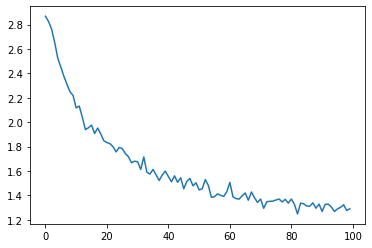

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show

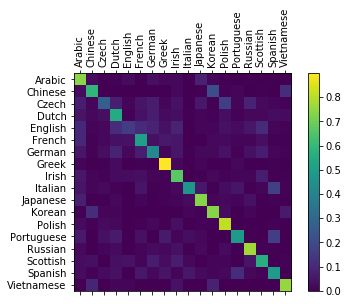

In [56]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [57]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.66) Russian
(-1.00) Czech
(-3.10) English

> Jackson
(-0.87) English
(-1.75) Russian
(-2.21) Scottish

> Satoshi
(-0.54) Arabic
(-1.24) Japanese
(-2.65) Polish
